In [16]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


In [17]:
# -------------------------------------- External Libraries --------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import time
# ----------------------------------------- Local Imports ----------------------------------------
from src.core                  import LoRaPhyParams, LoRaFrameParams
from src.mod                   import LoRaModulator
from src.demod                 import LoRaDemodulator
from src.sync                  import DechirpBasedSynchronizer
from src.core.vpn_utils        import VPNKeepAlive

import src.core.sdr_utils as sdr_utils
import src.core.snr_utils as snr_utils


In [18]:
def plot_snr_map(profile:snr_utils.SDRProfile):
    """
    Plot the SNR map from the given SDR profile.
    """
    atten_range = [point.attenuation for point in profile.snr_map]
    avg_snr = [np.mean(point.snr_values) for point in profile.snr_map]

    plt.figure(figsize=(10, 5))
    plt.plot(atten_range, avg_snr, marker='o')
    plt.title(f"SNR Map: {profile.name}")
    plt.xlabel("Tx Attenuation (dB)")
    plt.ylabel("Estimated SNR (dB)")
    plt.grid(True)
    plt.xticks(atten_range)
    plt.tight_layout()
    plt.show()


In [ ]:
def run_calibration(profile_name, atten_range, target_successful_samples, max_retries_per_atten, tx_sdr_params:sdr_utils.SDRParams, rx_sdr_params:sdr_utils.SDRParams, modulator:LoRaModulator, demodulator:LoRaDemodulator, synchronizer:DechirpBasedSynchronizer, fold_mode):
    """
    Run the SNR calibration process.
    
    :param target_successful_samples: Number of successful samples to collect per attenuation level.
    :param max_retries_per_atten: Maximum number of attempts per attenuation level.
    :param sdr_params: SDR parameters for the calibration.
    :param modulator: LoRa modulator instance.
    :param demodulator: LoRa demodulator instance.
    :param synchronizer: Synchronizer instance for frame synchronization.
    :return: A SDRProfile object containing the results of the calibration.
    """

    phy_params = modulator.phy_params
    frame_params = modulator.frame_params

    snr_map = defaultdict(list)

    payload_symbols = sdr_utils.optimize_payload_symbols(
        rx_sdr_params.rx_buffer_size,
        frame_params.preamble_symbol_count,
        phy_params.samples_per_symbol,
        pad_samples=0
    )
    rng = np.random.default_rng(23)
    payload = list(rng.integers(0, phy_params.chips_per_symbol, size=payload_symbols))

    modulated_full = modulator.modulate(payload, include_frame=True)
    #reference_payload = modulator.modulate(payload, include_frame=False)

    vpn_guard = VPNKeepAlive() # Mantiene la conexión VPN activa durante la calibración, ya que esta puede durar un tiempo largo
    #vpn_guard.reconnect()  # Asegurarse de que la VPN está conectada antes de comenzar
    
    
    # Reseteamos los SDRs por las dudas
    tx_sdr = sdr_utils.init_sdr(tx_sdr_params)
    rx_sdr = sdr_utils.init_sdr(rx_sdr_params)
    del tx_sdr
    del rx_sdr
    
    tx_sdr = sdr_utils.init_sdr(tx_sdr_params) 
    sdr_utils.change_sdr_attenuation(tx_sdr, -88) # Atenuación máxima, de todas formas se quieren transmitir ceros
    tx_sdr.tx(np.zeros(tx_sdr_params.rx_buffer_size, dtype=np.int16))  # Enviar ceros para evitar saturación inicial
    rx_sdr = sdr_utils.init_sdr(rx_sdr_params)
    time.sleep(tx_sdr_params.rx_buffer_size / tx_sdr_params.sample_rate) 
    for _ in range(2):
        _unused = tx_sdr.rx()
    
    iq_buffer = rx_sdr.rx() 
    noise_power = snr_utils.signal_power(iq_buffer)  # Calcular la potencia del ruido
    if noise_power == 0:
        raise RuntimeError("La potencia del ruido es cero, verifique la conexión de los SDRs o el entorno de prueba.")
    
    print(f"[SNR] Potencia de ruido[dB]: {10* np.log10(noise_power):.2f} dB")
    del tx_sdr
    del rx_sdr
    # Corrida de atenuación
    for idx, atten in enumerate(atten_range):

        vpn_guard.maybe_reconnect()  # Reconexión périódica de la VPN para evitar fallos de rekey

        print(f"[SNR] Probando TxAtten = {atten} dB ({idx + 1}/{len(atten_range)})...")

        success_cnt = 0
        attempt_cnt = 0

        while attempt_cnt < max_retries_per_atten and success_cnt < target_successful_samples:
            attempt_cnt += 1
            demodulator.backend.clear_memory()

            try:
                # ---------- TX / RX ----------
                tx_sdr = sdr_utils.init_sdr(tx_sdr_params)
                rx_sdr = sdr_utils.init_sdr(rx_sdr_params)
                sdr_utils.change_sdr_attenuation(tx_sdr, atten)

                tx_sdr.tx(modulated_full * (2**15 - 1))
                time.sleep(tx_sdr_params.rx_buffer_size / tx_sdr_params.sample_rate) 
                for _ in range(2):
                    _unused = tx_sdr.rx()

                iq_buffer = rx_sdr.rx()
                sdr_utils.soft_delete_sdr(tx_sdr)
                sdr_utils.soft_delete_sdr(rx_sdr)

            except Exception as e:
                print(f"This shouldn't happen.")
                raise

            try:
                noisy_signal_power = snr_utils.signal_power(iq_buffer)
                print(f"noisy_signal_power[dB]: {10 * np.log10(noisy_signal_power):.2f} dB")
                snr = (noisy_signal_power - noise_power) / noise_power
                snr_db = 10 * np.log10(snr)
                print(f"  ✓ intento {attempt_cnt}: SNR {snr_db:.2f} dB")

                snr_map[atten].append(snr_db)
                success_cnt += 1

            except Exception as e:
                print(f"  ✗ intento {attempt_cnt}: {e}")

        # ------ después del bucle ------

        if success_cnt == 0:
            print(f"  → no valid samples at {atten} dB (skipped)")
        else:
            print(f"  → kept {success_cnt} sample(s) at {atten} dB")
    
    # COnstruir el perfil SDR
    print("\n[INFO] Construyendo el perfil SDR...")
    atten_snr_points = [
        snr_utils.AttenSNRPoint(attenuation=att, snr_values=snrs)
        for att, snrs in sorted(snr_map.items())
    ]

    profile = snr_utils.SDRProfile(
        name=profile_name,
        fold_mode=fold_mode,
        tx_sdr_params=tx_sdr_params,
        rx_sdr_params=rx_sdr_params,
        phy_params=phy_params,
        frame_params=frame_params,
        snr_map=atten_snr_points
    )

    vpn_guard.disconnect()  # Desconectar VPN

    return profile




In [20]:
# --- Notebook Configuration ------------------------------------------
modulator_backend = "numpy"    
demodulator_backend = "cupy"   
fold_mode = "CPA"        

phy_params = LoRaPhyParams(
    spreading_factor=8,
    bandwidth=500e3,
    samples_per_chip=2
)

frame_params = LoRaFrameParams(
    preamble_symbol_count=8,
    explicit_header=True,
    sync_word=0x00
)

sdr_tx_params = sdr_utils.SDRParams(
    uri = "ip:192.168.1.32",
    sample_rate = int(phy_params.sample_rate),
    lo_freq = 938e6,
    loopback_mode = sdr_utils.LoopbackMode.OTA,
    rf_bandwidth = int(phy_params.sample_rate),
    tx_attenuation = -10,
    rx_gain_control=sdr_utils.RxGainControl(sdr_utils.RxGainControlMode.MANUAL, 40),
    rx_buffer_size= 2**20
)

sdr_rx_params = sdr_utils.SDRParams(
    uri = "ip:192.168.1.34",
    sample_rate = int(phy_params.sample_rate),
    lo_freq = 938e6,
    loopback_mode = sdr_utils.LoopbackMode.OTA,
    rf_bandwidth = int(phy_params.sample_rate),
    tx_attenuation = -10,
    rx_gain_control=sdr_utils.RxGainControl(sdr_utils.RxGainControlMode.MANUAL, 65),
    rx_buffer_size= 2**20
)

In [21]:
modulator = LoRaModulator(
    phy_params, 
    frame_params, 
    backend=modulator_backend
)

demodulator = LoRaDemodulator(
    phy_params,
    backend=demodulator_backend,
    fold_mode=fold_mode
)
synchronizer = DechirpBasedSynchronizer(
    phy_params,
    frame_params,
    backend=demodulator_backend,
    fold_mode=fold_mode,
    logging=True,
    max_sync_candidates=50
)

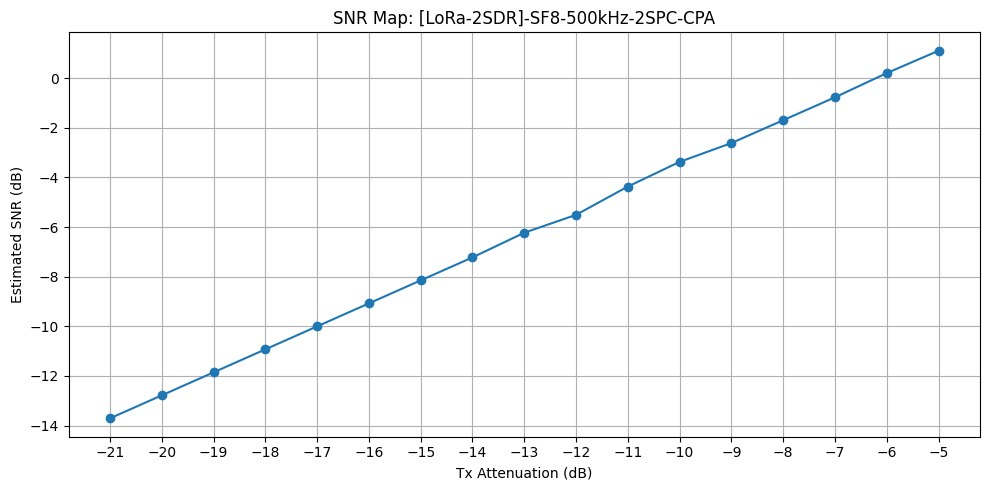

PosixPath('/home/fernando/Documents/LoRaPriv/persistence/sdrprofile/dual_lora_sdr/sf8_500k_2spc_cpa.json')

In [ ]:
profile = run_calibration(
    profile_name="[LoRa-2SDR]-SF8-500kHz-2SPC-CPA",
    atten_range=list(range(-5, -13, -1)),
    target_successful_samples=10,
    max_retries_per_atten=20,
    tx_sdr_params=sdr_tx_params,
    rx_sdr_params=sdr_rx_params,
    modulator=modulator,
    demodulator=demodulator,
    synchronizer=synchronizer,
    fold_mode=fold_mode
)
profile = snr_utils.SDRProfile.load("dual_lora_sdr/sf8_500k_2spc_cpa.json")
plot_snr_map(profile)
profile.save(f"dual_lora_sdr/sf8_500k_2spc_cpa.json")